### Tutorial on Clustering by Weighted Cuts in Directed Graphs

Reference:
[1] Marina Meila and William Pentney.
*Clustering by weighted cuts in directed graphs*.
<https://sites.stat.washington.edu/mmp/Papers/sdm-wcuts.pdf>

In [1]:
import sys
sys.path.insert(0,'/home/elizabeth/Desktop/GIT/Optimized_Ncut_Directed_and_Undirected/src')

from Clustering_by_weighted_cuts_in_directed_graphs import *
from vizualize_nx import *


First, lets build a networkx digraph to play with. Please note that this code will run with undirected graphs but the results will not be correct. There is a seperate notbook and .py file for undirected graphs.

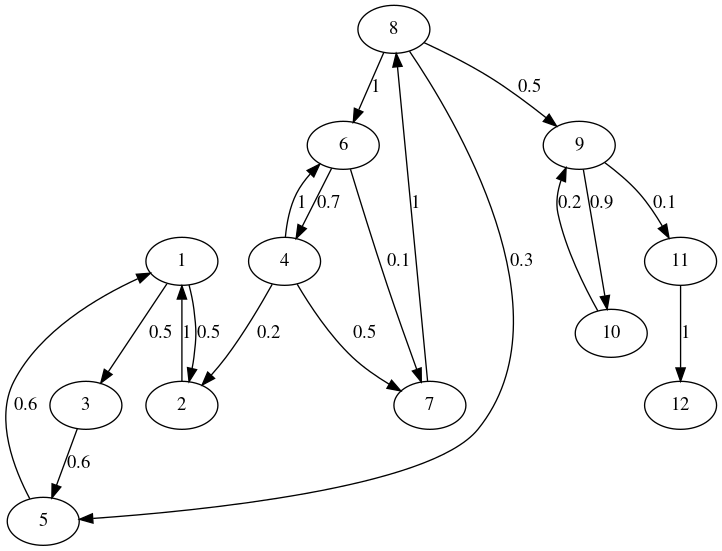

In [2]:
G = nx.DiGraph()
E = [(1,3), (2,1), (3,5), (5,1), (6,4), (4,7), (6,7), (4,6), (1, 2), (4, 2), (7,8), (8,6), (8,5), (8,9), (9,10), (10,9), (9,11), (11,12)]
w = [.5, 1, .6, .6, .7, .5, .1, 1, .5, .2, 1, 1, .3, .5, .9, .2, .1, 1]

for e in range(len(E)):
    s,t = E[e]
    G.add_edge(s,t, weight = w[e])

view_pydot(G, 'weight')


Now we set a few parameters, if edges are weights then set data to be the edge attribute key for the weight. If this is not specified, then edge weights are automatically set as 1. Similarly, the nodelist is just the set of nodes in G you are trying to find an optimum partition for. Reading results is easier if the nodes are orders, but this is not required so if it not specified then the nodelist is automatically set to be G.nodes().

In [3]:
data = 'weight'
nodelist = sorted(G.nodes())
nodelist

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Now we look at the weight matrix W and degree matrix D. Notice the W(i,j) entry is the weight of edge i --> j, and the D(i,i) entry is the sum of weights from all edges of node i. If a node i has no out edges, the D(i) is set to be 1 to avoid divison by zero later and to make node i a 'sink'.

In [4]:
W = asym_weight_matrix(G, nodelist, data)
W

array([[0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 1. , 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.7, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.3, 1. , 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [5]:
D = asym_weighted_degree_matrix(G, nodelist, data)
D

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.8, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

Now we compute the Hermitian part of nL, where nL is the normalised Laplacian. i.e., for T = D, nL = D^(-1/2)(D-W)D^(-1/2) = 1-D^(-1/2)WD^(-1/2). See reference [1] or code for more details on T and the Hermitian of a matrix. Then we can find the k smallest eigenvectors of the Hermitian part of nL and use it to partition the G. Using the second smallest eigenvector v2, partition the nodes into two groups basied on the signs of v2. 

In [6]:
L = Hermitian_normalized_Laplacian(D, W, D)
X = k_smallest_eigvec(nodelist, L, D, 2)
X

array([[-0.03010097,  0.58832305],
       [-0.02197067,  0.43620331],
       [-0.02870132,  0.49611064],
       [-0.04935118,  0.1513519 ],
       [-0.04679329,  0.54784175],
       [-0.10318328,  0.234051  ],
       [-0.06059939,  0.10653779],
       [-0.11676666,  0.12384916],
       [-0.69707686, -0.07692739],
       [-1.53092038, -0.20219873],
       [-0.03311504, -0.00476448],
       [-0.01322314, -0.00227693]])

Of course, all of this can be done with a single function, showing that the partition for the above graph has [1, 2, 3, 4, 5, 6, 7, 8] in one group and [9, 10, 11, 12]. Notice this partition should minimize the normalized cut!

In [7]:
v2, A, B = asym_optimized_normalized_cut(G, nodelist, data)
A, B

([1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12])

We can then partition G further just by restricting the nodeset, a visual of the partitions is also shown.

In [8]:
nodelist = A
v2, A1, B1 = asym_optimized_normalized_cut(G, nodelist, data)
print('Three cluster of G are:', B, A1, B1)

Three cluster of G are: [9, 10, 11, 12] [4, 6, 7, 8] [1, 2, 3, 5]


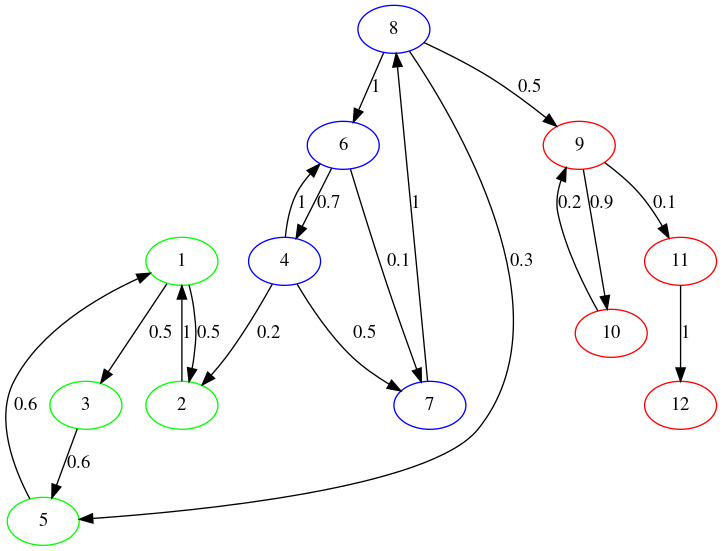

In [9]:
color = {}
for i in G:
    if i in B:
        color[i] = 'red'
    if i in A1:
        color[i] = 'blue'
    if i in B1:
        color[i] = 'green'
nx.set_node_attributes(G, color, 'color')

view_pydot(G, 'weight')